In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch_geometric.transforms as T
from torch_geometric.nn import Node2Vec
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import QM9

In [ ]:
# The qm7b dataset is doesent have node features, so we use the QM9 dataset instead.
# dataset_qm7b = QM7b(root='./data/QM7b')
# print(f'Number of graphs: {len(dataset_qm7b)}')

dataset = QM9(root='./data/QM9')
print(f'Number of graphs: {len(dataset)}')

Number of graphs: 130831


Data(x=[15, 11], edge_index=[2, 28], edge_attr=[28, 4], y=[1, 19], pos=[15, 3], idx=[1], name='gdb_7052', z=[15])
tensor([[ 5.8934e+00,  7.1140e+01, -7.3661e+00,  4.0001e-01,  7.7661e+00,
          1.4309e+03,  3.1658e+00, -9.8682e+03, -9.8679e+03, -9.8679e+03,
         -9.8691e+03,  3.1508e+01, -6.5792e+01, -6.6113e+01, -6.6473e+01,
         -6.1542e+01,  6.3397e+00,  8.4029e-01,  7.6542e-01]])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
   

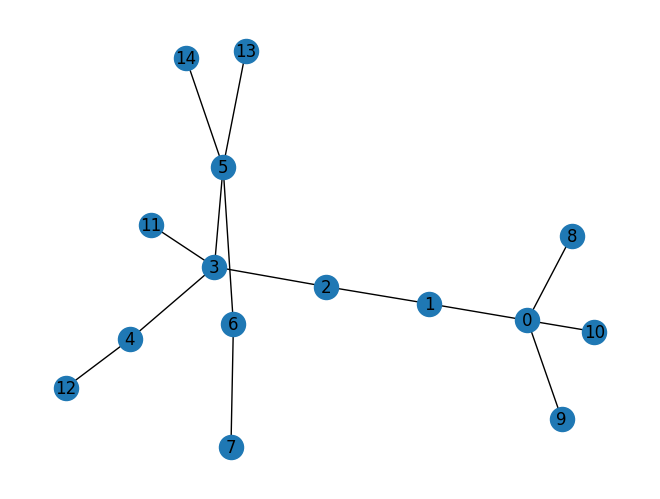

In [3]:
i = 6840

print(dataset[i])
print(dataset[i].y)
print(dataset[i].edge_attr)

g = to_networkx(dataset[i], to_undirected=True)
nx.draw(g, with_labels=True)

In [9]:
dataset = dataset[:10000]

In [10]:
length = len(dataset)
idx = np.random.permutation(length)
train_idx = idx[:int(0.8*length)]
val_idx = idx[int(0.8*length):int(0.9*length)]
test_idx = idx[int(0.9*length):]

train = [dataset[i] for i in train_idx]
val = [dataset[i] for i in val_idx]
test = [dataset[i] for i in test_idx]

print(f'Train: {len(train)} Val: {len(val)} Test: {len(test)}')


Train: 8000 Val: 1000 Test: 1000


In [11]:
def create_combined_graph(graph_dataset):
    combined_edge_index = []
    batch_indicators = []
    node_features = []
    offset = 0
    
    for i, data in enumerate(graph_dataset):
        # Add edges with offset node indices
        edges = data.edge_index + offset
        combined_edge_index.append(edges)
        
        # Track which nodes belong to which graph
        batch_indicators.extend([i] * data.num_nodes)
        
        # Store node features if they exist
        if hasattr(data, 'x') and data.x is not None:
            node_features.append(data.x)
        
        # Update offset for next graph
        offset += data.num_nodes
    
    # Concatenate all edges
    combined_edge_index = torch.cat(combined_edge_index, dim=1)
    
    # Concatenate node features if they exist
    if node_features:
        combined_node_features = torch.cat(node_features, dim=0)
    else:
        combined_node_features = None
    
    return combined_edge_index, torch.tensor(batch_indicators), combined_node_features

torch.Size([2, 249470]) torch.Size([125769])


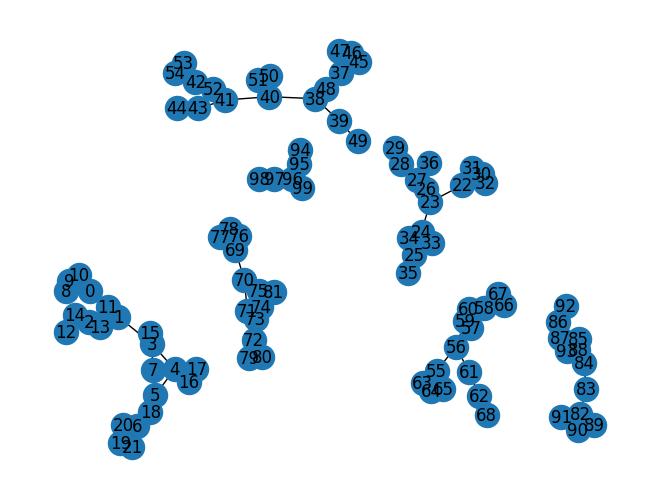

In [12]:
combined_edge_index, batch_indicators, combined_node_features = create_combined_graph(train)
print(combined_edge_index.shape, batch_indicators.shape)

combined_graph = Data(edge_index=combined_edge_index, x=combined_node_features, batch=batch_indicators)
small_g = to_networkx(combined_graph, to_undirected=True).subgraph(range(100))
nx.draw(small_g, with_labels=True)

In [7]:
def get_graph_embeddings(node_embeddings, batch_indicators, num_graphs):
    graph_embeddings = []
    for i in range(num_graphs):
        # Get embeddings for nodes in this graph
        mask = batch_indicators == i
        graph_node_embeddings = node_embeddings[mask]
        
        # Aggregate (mean pooling)
        graph_emb = graph_node_embeddings.mean(dim=0)
        graph_embeddings.append(graph_emb)
    
    return torch.stack(graph_embeddings)


In [13]:
def get_embeddings_for_graphs(graph_dataset, epochs, config):
    edge_index, batch, x = create_combined_graph(graph_dataset)
    
    model = Node2Vec(
        edge_index=edge_index,
        embedding_dim=config['embedding_dim'],
        walk_length=config['walk_length'],
        context_size=config['context_size'],
        walks_per_node=config['walks_per_node'],
        num_negative_samples=config['num_negative_samples'],
        p=config['p'],
        q=config['q'],
        sparse = False
    ).to(device)
    
    loader = model.loader(batch_size=256, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch: {epoch:02d}, Loss: {total_loss/len(loader):.4f}')
    
    # Get embeddings
    model.eval()
    with torch.no_grad():
        node_embeddings = model()
    
    # Convert to graph embeddings
    graph_embeddings = get_graph_embeddings(node_embeddings, batch, len(graph_dataset))
    
    return graph_embeddings


config = {
    'embedding_dim': 64,
    'walk_length': 10,
    'context_size': 5,
    'walks_per_node': 10,
    'num_negative_samples': 1,
    'p': 0.6,
    'q': 2.0
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Train')
x_train = get_embeddings_for_graphs(train, 10, config)
print('Val')
x_val = get_embeddings_for_graphs(val, 30, config)
print('Test')
x_test = get_embeddings_for_graphs(test, 30, config)


Train
Epoch: 01, Loss: 3.4967
Epoch: 02, Loss: 1.8925
Epoch: 03, Loss: 1.3200
Epoch: 04, Loss: 1.0347
Epoch: 05, Loss: 0.9028
Epoch: 06, Loss: 0.8393
Epoch: 07, Loss: 0.8065
Epoch: 08, Loss: 0.7883
Epoch: 09, Loss: 0.7787
Epoch: 10, Loss: 0.7742
Val
Epoch: 01, Loss: 4.4830
Epoch: 02, Loss: 3.0256
Epoch: 03, Loss: 2.4748
Epoch: 04, Loss: 2.1118
Epoch: 05, Loss: 1.8224
Epoch: 06, Loss: 1.5923
Epoch: 07, Loss: 1.4052
Epoch: 08, Loss: 1.2626
Epoch: 09, Loss: 1.1504
Epoch: 10, Loss: 1.0664
Epoch: 11, Loss: 1.0025
Epoch: 12, Loss: 0.9539
Epoch: 13, Loss: 0.9162
Epoch: 14, Loss: 0.8867
Epoch: 15, Loss: 0.8635
Epoch: 16, Loss: 0.8452
Epoch: 17, Loss: 0.8306
Epoch: 18, Loss: 0.8183
Epoch: 19, Loss: 0.8076
Epoch: 20, Loss: 0.7989
Epoch: 21, Loss: 0.7920
Epoch: 22, Loss: 0.7854
Epoch: 23, Loss: 0.7807
Epoch: 24, Loss: 0.7758
Epoch: 25, Loss: 0.7722
Epoch: 26, Loss: 0.7689
Epoch: 27, Loss: 0.7659
Epoch: 28, Loss: 0.7635
Epoch: 29, Loss: 0.7609
Epoch: 30, Loss: 0.7594
Test
Epoch: 01, Loss: 4.5242
E

In [14]:
x_train = x_train.detach()
x_val = x_val.detach()
x_test = x_test.detach()

y_train = torch.stack([data.y for data in train]).squeeze().to(device)
y_val = torch.stack([data.y for data in val]).squeeze().to(device)
y_test = torch.stack([data.y for data in test]).squeeze().to(device)

print(x_train.shape, y_train.shape)
print(x_train.device, y_train.device)


torch.Size([8000, 64]) torch.Size([8000, 19])
cuda:0 cuda:0


In [15]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error

class MultiTargetMLP(nn.Module):
    def __init__(self, input_dim=config['embedding_dim'], hidden_dims=[64, 128, 64], output_dim=14):
        super(MultiTargetMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.Dropout(0.2))
            prev_dim = dim
            
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)


In [16]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize model and optimizer
model = MultiTargetMLP(input_dim=x_train.shape[1], output_dim=y_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

# Training loop
n_epochs = 500
best_val_mse = float('inf')
patience = 50
counter = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val).item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val MSE: {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_val_mse:
        best_val_mse = val_loss
        counter = 0
        # Save model
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    test_preds = model(x_test).cpu().numpy()
    test_mse = mean_squared_error(y_test.cpu().numpy(), test_preds)
    print(f"Test MSE with MLP: {test_mse:.4f}")

Epoch 1/500, Train Loss: 22615369.9048, Val MSE: 19908522.0000
Epoch 2/500, Train Loss: 22613064.8889, Val MSE: 19902624.0000
Epoch 3/500, Train Loss: 22600042.4762, Val MSE: 19888992.0000
Epoch 4/500, Train Loss: 22583929.5238, Val MSE: 19869636.0000
Epoch 5/500, Train Loss: 22568661.9048, Val MSE: 19843518.0000
Epoch 6/500, Train Loss: 22533866.0317, Val MSE: 19811642.0000
Epoch 7/500, Train Loss: 22513452.1270, Val MSE: 19766888.0000
Epoch 8/500, Train Loss: 22466790.8889, Val MSE: 19720128.0000
Epoch 9/500, Train Loss: 22419658.8889, Val MSE: 19676022.0000
Epoch 10/500, Train Loss: 22366099.2063, Val MSE: 19613484.0000
Epoch 11/500, Train Loss: 22321014.8254, Val MSE: 19539570.0000
Epoch 12/500, Train Loss: 22258552.6984, Val MSE: 19477486.0000
Epoch 13/500, Train Loss: 22180902.7302, Val MSE: 19414918.0000
Epoch 14/500, Train Loss: 22114114.2857, Val MSE: 19324264.0000
Epoch 15/500, Train Loss: 22041535.9365, Val MSE: 19261712.0000
Epoch 16/500, Train Loss: 21968975.2063, Val MSE:

C:\Users\wittd\AppData\Local\Temp\ipykernel_17828\2236278886.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
